# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. 
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [4]:
def Q1(num_examples=5):
    ### STUDENT START ###
    labels = {0:"alt.altheism", 1:"comp.graphics", 2:"sci.space", 3:"talk.religion.misc"}
    subset_train, subset_labels = train_data[0:num_examples], train_labels[0:num_examples]
    for text, topic in zip(subset_train, subset_labels):
        print(labels[topic] + ": \n" + text)
        print("-"*10)
    ### STUDENT END ###

Q1(5)

comp.graphics: 
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
----------
talk.religion.misc: 


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.
----------
sc

### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [5]:
def Q2():
    ### STUDENT START ###
    
    # Creating vectorizer then creating matrix from vocabulary
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)
    
    # Retrieve size of the vocabulary
    vocab = vectorizer.get_feature_names()
    vocab_size = len(vocab)
    print(f"Size of (fitted) unigram feature matrix vocabulary: {vocab_size}")
    
    # The fraction of non-zero entries in the matrix
    print(f"Fraction of non-zero entries per example: {X.nnz/(X.shape[1] * X.shape[0])}")
    vocab_sorted = sorted(vocab)
    print(f"0th feature string: {vocab_sorted[0]} \nlast feature string: {vocab_sorted[vocab_size - 1]}")
    
    print("-" * 20)
    
    # Creating new vectorizer with predefined vocabulary
    vectorizer = CountVectorizer(vocabulary=["atheism", "graphics","space", "religion"])
    X = vectorizer.transform(train_data)
    
    # Confirming size of the vocabulary, getting ratio of nonzero values
    print(f"Size of vocabulary (should be 4): {len(vectorizer.get_feature_names())}")
    print(f'Average number of non-zero features per example for a vocabulary of ["atheism", "graphics", "space", "religion"]: {X.nnz / (X.shape[0] * X.shape[1])}')
    
    print("-" * 20)
    
    # Creating and fitting new vectorizer for bi- and tri-grams
    vectorizer = CountVectorizer(analyzer="word", ngram_range=(2,3))
    X = vectorizer.fit_transform(train_data)
    
    # Getting vocabulary size 
    print(f"Size of bi- and tri-gram feature matrix vocabulary: {len(vectorizer.get_feature_names())}")
    
    print("-" * 20)
    
    # Creating and fitting vectorizer for unigrams used in more than 10 documents
    vectorizer = CountVectorizer(min_df=10)
    X = vectorizer.fit_transform(train_data)
    
    # Retrieving vocabulary size 
    print(f"Size of vocabulary for unigrams that appear in more than 10 documents: {len(vectorizer.get_feature_names())}")
    
    print("-" * 20)
    
    # Creating and fitting vectorizer for unigrams in train and dev data
    train_vec = CountVectorizer()
    X = train_vec.fit_transform(train_data)

    dev_vec = CountVectorizer()
    y = dev_vec.fit_transform(dev_data)
    
    # Obtaining fraction of vocabulary words missing in the dev vectorizer vocabulary
    percent_missing = 1 - (len(dev_vec.get_feature_names()) / len(train_vec.get_feature_names()))
    print(f"Fraction of words missing in dev vocab from the training vocabulary: {percent_missing}")
    
    print("-" * 20)
    
    ### STUDENT END ###

Q2()

Size of (fitted) unigram feature matrix vocabulary: 26879
Fraction of non-zero entries per example: 0.0035978272269590263
0th feature string: 00 
last feature string: zyxel
--------------------
Size of vocabulary (should be 4): 4
Average number of non-zero features per example for a vocabulary of ["atheism", "graphics", "space", "religion"]: 0.06710914454277286
--------------------
Size of bi- and tri-gram feature matrix vocabulary: 510583
--------------------
Size of vocabulary for unigrams that appear in more than 10 documents: 3064
--------------------
Fraction of words missing in dev vocab from the training vocabulary: 0.395587633468507
--------------------


### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [6]:
def Q3():
    ### STUDENT START ###
    
    # Creating vectorizer for and transofrming training data
    train_vectorizer = CountVectorizer()
    train_transf = train_vectorizer.fit_transform(train_data)
    # Extracting vocabulary from training matrix
    train_vocab = train_vectorizer.get_feature_names()

    # Create vectorizer for dev data with the same vocabulary as training data
    dev_vectorizer = CountVectorizer(vocabulary=train_vocab)
    dev_transf = dev_vectorizer.transform(dev_data)
    
    # Producing and evaluating KNN models with different K values
    ks = [1, 3, 5, 7, 9, 11, 13]
    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski')
        knn.fit(train_transf, train_labels)
        y_pred = knn.predict(dev_transf)
        f1 = metrics.f1_score(y_pred, dev_labels, average="weighted")
        print(f"KNN f1 score for k = {k} : {f1}")
    print("-" * 20)
    
    # Producing and evaluating Multinomial NB models with different alpha values 
    alphas = [0.0000000001, 0.00001, 0.0001, 0.01, 0.1, 0.5, 1]
    for alpha in alphas:
        MNB = MultinomialNB(alpha=alpha)
        MNB.fit(train_transf, train_labels)
        y_pred = MNB.predict(dev_transf)
        f1 = metrics.f1_score(y_pred, dev_labels, average="weighted")
        print(f"Multinomial NB f1 score for alpha = {alpha} : {f1}")
    print("-" * 20)
    
    # Producing and evaluating Logistic Regression models with different C values 
    cs = [0.00001, 0.0001, 0.01, 0.1, 0.5, 1, 1.5, 2]
    for c in cs:
        model = LogisticRegression(C=c, solver="liblinear", multi_class="auto")
        model.fit(train_transf, train_labels)
        y_pred = model.predict(dev_transf)
        f1 = metrics.f1_score(y_pred, dev_labels, average='weighted')
        squared_weights_sum = np.sum(model.coef_ ** 2)
        print(f"Logistic Regression f1 score for C = {c} : {f1}\nSum of squared weights: {squared_weights_sum}")
    print("-" * 20)
    
    ### STUDENT END ###

Q3()

KNN f1 score for k = 1 : 0.38576918749596
KNN f1 score for k = 3 : 0.41998734432014306
KNN f1 score for k = 5 : 0.4173931225320104
KNN f1 score for k = 7 : 0.4370948644358654
KNN f1 score for k = 9 : 0.42438012794232743
KNN f1 score for k = 11 : 0.4106673046392548
KNN f1 score for k = 13 : 0.42211045781620815
--------------------
Multinomial NB f1 score for alpha = 1e-10 : 0.7616350823604072
Multinomial NB f1 score for alpha = 1e-05 : 0.7673608423935595
Multinomial NB f1 score for alpha = 0.0001 : 0.775626667978903
Multinomial NB f1 score for alpha = 0.01 : 0.7840052757787004
Multinomial NB f1 score for alpha = 0.1 : 0.7954935780581611
Multinomial NB f1 score for alpha = 0.5 : 0.7906367807235509
Multinomial NB f1 score for alpha = 1 : 0.7843981539130703
--------------------
Logistic Regression f1 score for C = 1e-05 : 0.48983641839675346
Sum of squared weights: 0.0016499203317117306
Logistic Regression f1 score for C = 0.0001 : 0.5708257136190996
Sum of squared weights: 0.0381808619168

ANSWER: The KNN model is not a good choice for this problem given the relatively sparse dataset and the model's high sensitivity to outliers. These two result in the model's poor performance. The strong independence assumptions in NB models account for better performance relative to Logistic Regression models. In Logistic Regression, lower values of C result in higher penalties for large coefficients, as a result, low values of C result in a low squared sum of the weights and higher values of C correspond to higher weights. 

### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


In [7]:
def Q4():
    ### STUDENT START ###
    
    # Create vectorizer for and transforming train data 
    train_vectorizer = CountVectorizer(analyzer="word", ngram_range=(2, 2))
    train_transf = train_vectorizer.fit_transform(train_data)
    # Extracting vocabulary from training matrix
    train_vocab = train_vectorizer.get_feature_names()

    # Create vectorizer for dev data with the same vocabulary as training data
    dev_vectorizer = CountVectorizer(vocabulary=train_vocab)
    dev_transf = dev_vectorizer.transform(dev_data)
    
    # Fitting a Logistic Regression model with C = 0.5
    model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    model.fit(train_transf, train_labels)
    coeffs = model.coef_
    
    # Extracting top features by topic
    top_feature_indices_by_topic, top_features_by_topic, weights = np.argsort(-coeffs)[:, :5], [[] for i in range(4)], [[] for i in range(4)]
    row = 0
    for i in top_feature_indices_by_topic:
        for j in i:
            top_features_by_topic[row].append(train_vocab[j])
        row += 1
        
    # Extracting weights for top 20 features for each topic 
    for j in range(4):
        curr_weights = []
        for i in np.array(top_feature_indices_by_topic).reshape(20):
            curr_weights.append(coeffs[j, i])
        weights[j] = curr_weights
     
    # Constructing DataFrame from data above 
    df = pd.DataFrame(data={'alt.atheism': weights[0], 
                            'talk.religion.misc': weights[1],
                            'comp.graphics': weights[2],
                            'sci.space': weights[3]},
                      index=np.array(top_features_by_topic).reshape(20))
    return df 
    
    ### STUDENT END ###

Q4()

,alt.atheism,talk.religion.misc,comp.graphics,sci.space
claim that,0.605549,-0.199061,-0.274387,-0.140369
cheers kent,0.555719,-0.697920,-0.663783,0.534813
was just,0.482050,-0.131426,-0.128863,-0.227464
you are,0.472741,-0.279907,-0.481425,0.028365
are you,0.446954,-0.248254,-0.097166,-0.305624
looking for,-0.630341,1.108371,-0.499932,-0.571861
in advance,-0.459351,0.832569,-0.438494,-0.418455
comp graphics,-0.292166,0.801205,-0.370910,-0.285185
out there,-0.274802,0.758660,-0.479013,-0.277086
is there,-0.340882,0.755005,-0.468252,-0.257083


ANSWER: I found it strange that the bigrams `you are` and `are you` display significantly different weights for different topics. For the space topic, `you are` has a weight of $\approx0.03$ whilst `are you` has a negative weight of $\approx-0.3$. With this being said, there are significantly more stop word bigrams than I thought there would be. This is surprising to me because stop words are usually removed when preprocessing textual data, and seeing them here with high valued weights is conterintuitive to that process. Realistically, these stop words should have similar weights accross all topics. 

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [9]:
def Q5():
    ### STUDENT START ###
    
    raw_train_vectorizer = CountVectorizer(lowercase=False, strip_accents=None)
    train_transf = raw_train_vectorizer.fit_transform(train_data)
    train_vocab = raw_train_vectorizer.get_feature_names()
    raw_dev_vectorizer = CountVectorizer(vocabulary=train_vocab, 
                                         lowercase=False, strip_accents=None)
    dev_transf = raw_dev_vectorizer.transform(dev_data)
    
    def fit_and_evaluate_model(training_set, development_set):
        model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
        model.fit(training_set, train_labels)
        y_pred = model.predict(development_set)
        f1 = metrics.f1_score(y_pred, dev_labels, average="weighted")
        return f1
    
    f1 = fit_and_evaluate_model(train_transf, dev_transf)
    print(f"Unprocessed data vocabulary size: {len(train_vocab)}, Logistic Regression f1 score: {f1}")
    
    # Preprocessing data
    # Getting stop words from the nltk library
    nltk.download('stopwords', quiet="True")
    stopwords = nltk.corpus.stopwords.words("english")

    # Inspiration for lemmatizer here: https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
    nltk.download('wordnet', quiet="True")
    lemmatizer = nltk.wordnet.WordNetLemmatizer()
    
    def preprocess_text(data):
        counter = 0 
        preprocessed_text = [0 for i in range(len(data))]
        for text in data:
            # Replacing apostrophes with empty spaces 
            text_no_apost = text.replace("'", "")

            # Removing anything that is not in the alphabet
            cleaner = re.sub('[^a-zA-Z]', ' ', text_no_apost)
            cleaner = cleaner.lower()
            cleaner = cleaner.split()

            # Lemmatizing text
            cleaner = [lemmatizer.lemmatize(word) for word in cleaner if not word in stopwords]
            cleaned = ' '.join(cleaner)
            preprocessed_text[counter] = cleaned
            counter += 1
        return preprocessed_text
    
    
    # Preprocessing train and dev data
    preprocessed_train_data = preprocess_text(train_data)
    preprocessed_dev_data = preprocess_text(dev_data)
    
    # Vectorizing pre-processed data
    train_vectorizer = CountVectorizer()
    train_transf = train_vectorizer.fit_transform(preprocessed_train_data)
    train_vocab = train_vectorizer.get_feature_names()
    dev_vectorizer = CountVectorizer(vocabulary=train_vocab)
    dev_transf = dev_vectorizer.transform(dev_data)
    
    # Creating and evaluating model 
    f1 = fit_and_evaluate_model(train_transf, dev_transf)
    print(f"Preprocessed data vocabulary size: {len(train_vocab)}, Logistic Regression f1 score: {f1}")
    ### STUDENT END ###

Q5()

Unprocessed data vocabulary size: 33291, Logistic Regression f1 score: 0.7161660045275731
Preprocessed data vocabulary size: 21531, Logistic Regression f1 score: 0.7252534975703547


### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

L1 Regularization strength: 0.01, Vocabulary size: 17, Log Vocabulary size: 2.833213344056216, L2 Logistic Regression f1 score: 0.49602625292291236
L1 Regularization strength: 0.08, Vocabulary size: 181, Log Vocabulary size: 5.198497031265826, L2 Logistic Regression f1 score: 0.6821796135291223
L1 Regularization strength: 0.09, Vocabulary size: 197, Log Vocabulary size: 5.2832037287379885, L2 Logistic Regression f1 score: 0.6972739491191375
L1 Regularization strength: 0.1, Vocabulary size: 211, Log Vocabulary size: 5.351858133476067, L2 Logistic Regression f1 score: 0.7062873304694209
L1 Regularization strength: 0.2, Vocabulary size: 364, Log Vocabulary size: 5.8971538676367405, L2 Logistic Regression f1 score: 0.6957853849847617
L1 Regularization strength: 0.3, Vocabulary size: 524, Log Vocabulary size: 6.261491684321042, L2 Logistic Regression f1 score: 0.6870559821163689
L1 Regularization strength: 0.4, Vocabulary size: 646, Log Vocabulary size: 6.470799503782602, L2 Logistic Regres

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


L1 Regularization strength: 1.5, Vocabulary size: 1349, Log Vocabulary size: 7.207118856207756, L2 Logistic Regression f1 score: 0.699632750749956
L1 Regularization strength: 2, Vocabulary size: 1514, Log Vocabulary size: 7.322510433997394, L2 Logistic Regression f1 score: 0.6996782739957936


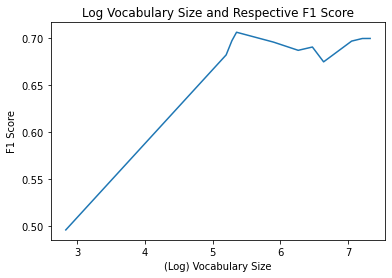

In [10]:
def Q6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ### 
    f1_scores, log_vocab_sizes = [], []

    # Creating vectorizer for and transofrming training data
    train_vectorizer = CountVectorizer()
    train_transf = train_vectorizer.fit_transform(train_data)
    # Extracting vocabulary from training matrix
    train_vocab = train_vectorizer.get_feature_names()

    # Creating L1 and L2 Logistic Regression models with different c values for L1 regularization
    cs = [0.01, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2]
    for c in cs: 
        # Building LogisticRegression model to find nonzero weights
        model = LogisticRegression(C=c, solver="liblinear", multi_class="auto", penalty="l1", tol=0.015)
        model.fit(train_transf, train_labels)

        # Extracting vocabulary words with nonzero weights
        nonzero_weights = np.nonzero(model.coef_)
        nonzero_vocabulary = np.unique(np.array(train_vocab)[nonzero_weights[1]])

        # Create new vectorizer from new vocabulary 
        new_train_vectorizer = CountVectorizer(vocabulary=nonzero_vocabulary)
        new_train_transf = new_train_vectorizer.transform(train_data)

        # Create vectorizer for dev data with the same vocabulary as training data
        dev_vectorizer = CountVectorizer(vocabulary=nonzero_vocabulary)
        dev_transf = dev_vectorizer.transform(dev_data)
        
        # Creating L2 Linear Regression model with new reduced vocabulary
        l2_model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto", penalty="l2")
        l2_model.fit(new_train_transf, train_labels)

        # Evaluating model performance
        y_pred = l2_model.predict(dev_transf)
        f1 = metrics.f1_score(y_pred, dev_labels, average="weighted")

        f1_scores.append(f1)
        log_vocab_sizes.append(np.log(len(nonzero_vocabulary)))

        print(f"L1 Regularization strength: {c}, Vocabulary size: {len(nonzero_vocabulary)}, Log Vocabulary size: {np.log(len(nonzero_vocabulary))}, L2 Logistic Regression f1 score: {f1}")
    
    # Plotting code
    plt.plot(log_vocab_sizes, f1_scores)
    plt.title("Log Vocabulary Size and Respective F1 Score")
    plt.xlabel("(Log) Vocabulary Size")
    plt.ylabel("F1 Score")
    plt.show();

    ### STUDENT END ###

Q6()

ANSWER: What we see here is that as the logged vocabulary size increases, the f1 score increases with it. However, at a log vocabulary size of around 5, this upwards trend dissapears and what we have instead is a f1 score that is spiking at around 6.5 log vocabulary size, then decreasing, and then rising again near a log vocabulary size of 7.

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [11]:
def Q7():
    ### STUDENT START ###
    
    # Vectorizing data with Td-Idf
    vectorizer = TfidfVectorizer(stop_words="english")
    train_transf = vectorizer.fit_transform(train_data)
    dev_transf = vectorizer.transform(dev_data)
    
    # Creating and fitting model 
    model = LogisticRegression(C=100, solver="liblinear", multi_class="auto", penalty="l2")
    model.fit(train_transf, train_labels)
    
    # Evaluating model 
    y_pred = model.predict(dev_transf)
    f1 = metrics.f1_score(y_pred, dev_labels, average="weighted")
    print(f"Tf-Idf Logistic Regression f1 score: {f1}")
    
    # Extracting predicted probabilities
    predicted_probs = model.predict_proba(train_transf)
    
    # Computing R ratios
    row = 0
    r_ratios = []
    for i in train_labels:
        correct_label_prob = predicted_probs[row, i]
        max_prob = max(predicted_probs[row])
        r_ratios.append(max_prob/correct_label_prob)
        row += 1
    
    # Sorting R Ratio indices by descending order
    indices_desc = np.argsort(-np.array(r_ratios))
    
    # Extracting documents with the highest R ratios
    for i in range(3):
        string = train_data[indices_desc[i]]
        r_ratio = r_ratios[indices_desc[i]]
        print(f"Document: {string} ; R Ratio: {r_ratio}")

    ### STUDENT END ###

Q7()

Tf-Idf Logistic Regression f1 score: 0.785240106964748
Document:  ; R Ratio: 1.4729316826252155
Document:   ; R Ratio: 1.4729316826252155
Document:  ; R Ratio: 1.4729316826252155


ANSWER: `CountVectorizer` simply computes the count for each word in the dataset. This results in rarely used words being weighted less although they might be important in the overall model generation. `TfidfVectorizer` addresses this by inversely weighting the frequency of words in one entry by that word's appearance in the whole document. In turn, rare words are given higher weights with the `TfidfVectorizer` than with the `CountVectorizer`. Looking at the top 3 documents in terms of R-ratio, we can see that the vectorizer is not sensitive to emptry strings. We can remove these from the overall training data. 

### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.